### Inits

In [437]:
import pylab
from pylab import *

#Matplotlib defs
import matplotlib
matplotlib.rcParams['text.usetex'] = True
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

#Numpy
import numpy as np
from numpy.random import multivariate_normal


from scipy import stats
from scipy.interpolate import interp1d as int1d
from scipy.special import erfc as erfc


import random

#Astropy
from astropy.cosmology import Planck15 as cosmo
from astropy.cosmology import z_at_value
from astropy.coordinates import SkyCoord
from astropy.coordinates import CartesianRepresentation
import astropy.units as u
from astropy.io import fits
from astropy import constants as const

#GetDist
from getdist import plots, MCSamples
import getdist

### Data Read

In [470]:
hdul = fits.open('DR7.fits')
data = hdul[1].data  # First extension is the table!
ra = data['RA']
dec = data['DEC']
z = data['REDSHIFT']
mass = data['LOGBH']
dmass = data['LOGBH_ERR']


#define restricted parameters and indicators
m_min=8
z_max=2.5
z_min=0.4
ra_min=120
ra_max=240
dec_min=10
dec_max=50

inds=(mass>m_min) & (z < z_max) & (dec > dec_min) & (dec < dec_max) & (ra > ra_min) & (ra < ra_max) & (z > z_min) 

# restricted arrays
z_new=z[inds]
dec_new=dec[inds]
ra_new=ra[inds]
mass_new=mass[inds]
dmass_new=dmass[inds]
dist_new=cosmo.comoving_distance(z_new)
QSO_coord = SkyCoord(ra_new*u.degree, dec_new*u.degree, frame='icrs', distance = dist_new)



# Duty-cycle digitized
lam06=np.loadtxt(open('../digi/lam06.csv'), delimiter=",")
lam03=np.loadtxt(open('../digi/lam03.csv'), delimiter=",")
minL=np.loadtxt(open('../digi/minL.csv'), delimiter=",")
lam03=np.vstack((lam03,[lam03[-1,0]+5,lam03[-1,1]]))
lam06=np.vstack((lam06,[lam06[-1,0]+5,lam06[-1,1]]))
minL=np.vstack((minL,[minL[-1,0]+5,minL[-1,1]]))
intlam06=int1d(lam06[:,0]-0.02,10**lam06[:,1],kind=1)
intlam03=int1d(lam03[:,0]-0.01,10**lam03[:,1],kind=1)
intminL=int1d(minL[:,0],10**minL[:,1],kind=1)

### Functions and constants

In [141]:
#Co-moving to Angular Diameter distance
cmd_to_add=int1d(logspace(-2,4.1,200),cosmo.angular_diameter_distance(np.array([z_at_value(cosmo.comoving_distance,x*u.Mpc) for x in logspace(-2,4.1,200)])).value)


#convertion constatn from M⊙/Mpc to angular size of BH shaddow in μarcsec: 5GM⊙/c^2*Mpc
msun_over_Mpc_to_muas=(5*(const.G*u.M_sun/(const.c**2*u.Mpc))*u.rad).to(u.uas).value

#convertion constatn from M⊙/Mpc*(200 km/sec)^2 to angular size (arcsec) 
# of the gravitational influance size of BH: GM⊙/(200 km/sec)^2*Mpc
msun_over_Mpc_as=((const.G*u.M_sun/((200*u.km/u.s)**2*u.Mpc))*u.rad).to(u.arcsec).value


# a function that returns M/sig^2 using the M-sig relation, in units of Msun/(200 km/sec)^2
def M_over_sig2(log10M):
    return 7539*10**(0.543379*log10M)

# Random Arrays

### Generating Arrays

In [588]:
npoints=30
rand_ra=ra_min+(ra_max-ra_min)*(np.random.random_sample((npoints)))
rand_dec=dec_min+(dec_max-dec_min)*(np.random.random_sample((npoints)))
rand_z=0.4+(2.5-0.4)*(np.random.random_sample((npoints)))
rand_pos=cosmo.comoving_distance(rand_z)

lamlis=intminL(mass_new)

cory=np.array([SkyCoord(rr*u.degree, dd*u.degree, frame='icrs', distance = zz) for rr in rand_ra for dd in rand_dec for zz in rand_pos])

In [589]:
rand_dist=np.array([(x.separation_3d(QSO_coord).value)*(lamlis)**(1/3) for x in cory[:15000]])

In [590]:
qshadarr=np.array([np.log10(msun_over_Mpc_to_muas)+mass_new-np.log10(x) for x in rand_dist]) 

In [587]:
30**3

27000

## Functions

In [469]:
# Probability that theta_shad>theta
def F_shad(x,sig):
    xos=x/(np.sqrt(2)*sig)
    return x*erfc(xos)-np.sqrt(2/np.pi)*sig*np.exp(-xos**2)

def P_shad(Q,sig):
    return (1/(4*0.17))*(F_shad(Q+0.17,sig)-F_shad(Q-0.17,sig))

def Gauss(m,mb,sig):
    return 1/(sig * np.sqrt(2 * np.pi)) *np.exp( - (m - mb)**2 / (2 * sig**2) )

array([7.40925039e-004, 1.78875790e-021, 1.79136766e-178])

In [591]:
theta_m1_shad_arr=np.array([P_shad(-1-x,dmass_new/mass_new) for x in qshadarr])
theta_1_shad_arr=np.array([P_shad(1-x,dmass_new/mass_new) for x in qshadarr])
theta_0_shad_arr=np.array([P_shad(-0-x,dmass_new/mass_new) for x in qshadarr])

In [592]:
theta_m1_shad_mean=np.median(theta_m1_shad_arr,axis=0)
theta_1_shad_mean=np.median(theta_1_shad_arr,axis=0)
theta_0_shad_mean=np.median(theta_0_shad_arr,axis=0)

In [593]:
new_0_9=np.array([az.hpd(x, 0.9) for x in np.transpose(theta_0_shad_arr)])
new_1_9=np.array([az.hpd(x, 0.9) for x in np.transpose(theta_1_shad_arr)])
new_m1_9=np.array([az.hpd(x, 0.9) for x in np.transpose(theta_m1_shad_arr)])

/Users/nadavoutmezguine/opt/anaconda3/lib/python3.7/site-packages/arviz/stats/stats.py:338: UserWarning: hpd will be deprecated Please replace hdi
  ("hpd will be deprecated " "Please replace hdi"),


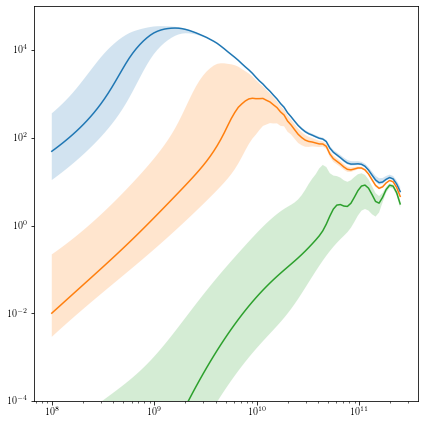

In [594]:
fig, ax = plt.subplots(figsize=(6, 6), tight_layout=True)

ax.loglog(10**bins,np.array([np.sum(Gauss(x,mass_new,dmass_new)*theta_m1_shad_mean) for x in bins]))
ax.fill_between(10**bins,np.array([np.sum(Gauss(x,mass_new,dmass_new)*new_m1_9[:,1]) for x in bins]),np.array([np.sum(Gauss(x,mass_new,dmass_new)*new_m1_9[:,0]) for x in bins]), alpha=0.2)

ax.loglog(10**bins,np.array([np.sum(Gauss(x,mass_new,dmass_new)*theta_0_shad_mean) for x in bins]))
ax.fill_between(10**bins,np.array([np.sum(Gauss(x,mass_new,dmass_new)*new_0_9[:,1]) for x in bins]),np.array([np.sum(Gauss(x,mass_new,dmass_new)*new_0_9[:,0]) for x in bins]), alpha=0.2)

ax.loglog(10**bins,np.array([np.sum(Gauss(x,mass_new,dmass_new)*theta_1_shad_mean) for x in bins]))
ax.fill_between(10**bins,np.array([np.sum(Gauss(x,mass_new,dmass_new)*new_1_9[:,1]) for x in bins]),np.array([np.sum(Gauss(x,mass_new,dmass_new)*new_1_9[:,0]) for x in bins]), alpha=0.2)

plt.ylim(10**(-4),10**5)

plt.show()

In [530]:
theta_m1_shad_mean=np.median(theta_m1_shad_arr,axis=0)
theta_m1_shad_std=np.std(theta_m1_shad_arr,axis=0)
theta_m1_shad_p10=np.percentile(theta_m1_shad_arr,10,axis=0)
theta_m1_shad_p90=np.percentile(theta_m1_shad_arr,90,axis=0)

In [531]:
theta_1_shad_mean=np.median(theta_1_shad_arr,axis=0)
theta_1_shad_std=np.std(theta_1_shad_arr,axis=0)
theta_1_shad_p10=np.percentile(theta_1_shad_arr,10,axis=0)
theta_1_shad_p90=np.percentile(theta_1_shad_arr,90,axis=0)

In [532]:
theta_0_shad_mean=np.median(theta_0_shad_arr,axis=0)
theta_0_shad_std=np.std(theta_0_shad_arr,axis=0)
theta_0_shad_p10=np.percentile(theta_0_shad_arr,10,axis=0)
theta_0_shad_p90=np.percentile(theta_0_shad_arr,90,axis=0)

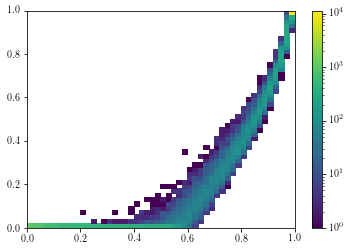

In [497]:
plt.hist2d(theta_m1_shad_mean,theta_m1_shad_p10,bins=50, norm=mcolors.LogNorm())
plt.colorbar()
plt.show()

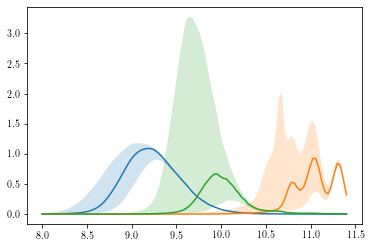

In [533]:
bins=np.linspace(8,11.4,100)
plt.plot(bins,np.array([np.sum(Gauss(x,mass_new,dmass_new)*theta_m1_shad_mean) for x in bins])/30000)
plt.fill_between(bins,np.array([np.sum(Gauss(x,mass_new,dmass_new)*theta_m1_shad_p90) for x in bins])/30000,np.array([np.sum(Gauss(x,mass_new,dmass_new)*theta_m1_shad_p10) for x in bins])/30000, alpha=0.2)

plt.plot(bins,np.array([np.sum(Gauss(x,mass_new,dmass_new)*theta_1_shad_mean) for x in bins])/10)
plt.fill_between(bins,np.array([np.sum(Gauss(x,mass_new,dmass_new)*theta_1_shad_p90) for x in bins])/10,np.array([np.sum(Gauss(x,mass_new,dmass_new)*theta_1_shad_p10) for x in bins])/10, alpha=0.2)

plt.plot(bins,np.array([np.sum(Gauss(x,mass_new,dmass_new)*theta_0_shad_mean) for x in bins])/1500)
plt.fill_between(bins,np.array([np.sum(Gauss(x,mass_new,dmass_new)*theta_0_shad_p90) for x in bins])/1500,np.array([np.sum(Gauss(x,mass_new,dmass_new)*theta_0_shad_p10) for x in bins])/1500, alpha=0.2)

plt.show()

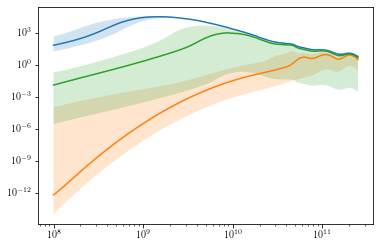

In [581]:
bins=np.linspace(8,11.4,100)
plt.loglog(10**bins,np.array([np.sum(Gauss(x,mass_new,dmass_new)*theta_m1_shad_mean) for x in bins]))
plt.fill_between(10**bins,np.array([np.sum(Gauss(x,mass_new,dmass_new)*theta_m1_shad_p90) for x in bins]),np.array([np.sum(Gauss(x,mass_new,dmass_new)*theta_m1_shad_p10) for x in bins]), alpha=0.2)

plt.loglog(10**bins,np.array([np.sum(Gauss(x,mass_new,dmass_new)*theta_1_shad_mean) for x in bins]))
plt.fill_between(10**bins,np.array([np.sum(Gauss(x,mass_new,dmass_new)*theta_1_shad_p90) for x in bins]),np.array([np.sum(Gauss(x,mass_new,dmass_new)*theta_1_shad_p10) for x in bins])/10, alpha=0.2)

plt.loglog(10**bins,np.array([np.sum(Gauss(x,mass_new,dmass_new)*theta_0_shad_mean) for x in bins]))
plt.fill_between(10**bins,np.array([np.sum(Gauss(x,mass_new,dmass_new)*theta_0_shad_p90) for x in bins]),np.array([np.sum(Gauss(x,mass_new,dmass_new)*theta_0_shad_p10) for x in bins])/1500, alpha=0.2)

plt.show()

In [572]:
import arviz as az
new_0_9=np.array([az.hpd(x, 0.9) for x in np.transpose(theta_0_shad_arr)])
new_1_9=np.array([az.hpd(x, 0.9) for x in np.transpose(theta_1_shad_arr)])
new_m1_9=np.array([az.hpd(x, 0.9) for x in np.transpose(theta_m1_shad_arr)])



/Users/nadavoutmezguine/opt/anaconda3/lib/python3.7/site-packages/arviz/stats/stats.py:338: UserWarning: hpd will be deprecated Please replace hdi
  ("hpd will be deprecated " "Please replace hdi"),


In [577]:
new_m1_9[:,1].shape

(38928,)

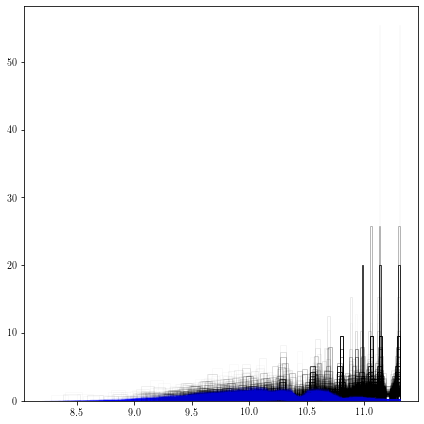

In [346]:
afig, ax = plt.subplots(figsize=(6, 6), tight_layout=True)
for x in qshadarr:
    tem=mass_new[x>1]
    ax.hist(tem,histtytransposetep',alpha=0.02,color='black',bins=20,density=1)
    
for x in qshadarr:
    tem=mass_new[x>0.5]
    ax.hist(tem,histtype='step',alpha=0.02,color='blue',bins=20,density=1)

plt.show()

In [419]:
bins=np.linspace(8,11.4,15)
his1=np.array([np.histogram(mass_new[x>1],bins=bins,density=1)[0] for x in qshadarr])
mean1=np.mean(his1,axis=0)
v1=np.std(his1,axis=0)

hisp5=np.array([np.histogram(mass_new[x>.5],bins=bins,density=1)[0] for x in qshadarr])
meanp5=np.mean(hisp5,axis=0)
vp5=np.std(hisp5,axis=0)

hisp1=np.array([np.histogram(mass_new[x>0],bins=bins,density=1)[0] for x in qshadarr])
meanp1=np.mean(hisp1,axis=0)
vp1=np.std(hisp1,axis=0)


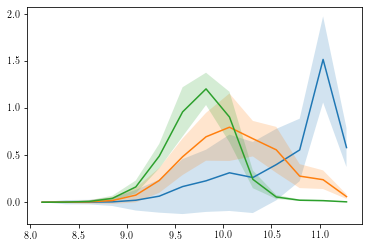

In [420]:
plt.plot((bins[1:]+bins[:-1])/2,mean1)
plt.fill_between((bins[1:]+bins[:-1])/2,mean1+v1,mean1-v1, alpha=0.2)
plt.plot((bins[1:]+bins[:-1])/2,meanp5)
plt.fill_between((bins[1:]+bins[:-1])/2,meanp5+vp5,meanp5-vp5, alpha=0.2)
plt.plot((bins[1:]+bins[:-1])/2,meanp1)
plt.fill_between((bins[1:]+bins[:-1])/2,meanp1+vp1,meanp1-vp1, alpha=0.2)
plt.show()

In [299]:
m_d_lis=np.transpose(np.array([np.tile(mass_new,1000),rand_dist.flatten()]))
names = ["mass", "distance"]
labels =  ['$\log_{10}(M_{\\rm{BH}}/M_\odot)$' , '$\\rm{distance\;[Mpc]}$']

# logfin2=np.transpose(np.vstack((fin2[:,0],show.log10(fin2[:,1]))))


samples = MCSamples(samples=m_d_lis,names = names, labels = labels,settings={'smooth_scale_2D':0.3,'contours': [0.90, 0.99]})


# g = plots.get_single_plotter(width_inch=4, ratio=1)
# g.plot_2d(samples, 'x0', 'x1', filled=True)
# g.add_legend(['sim 1', 'sim 2'], colored_text=True);

# Triangle plot
g = plots.get_subplot_plotter(subplot_size=3)
g.triangle_plot(samples, filled=True)


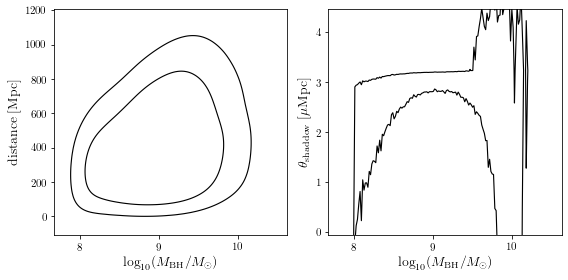

In [172]:


p = samples.getParams() 
samples.addDerived(msun_over_Mpc_to_muas*(10**p.mass)/p.distance, name='shad', label='$\\theta_{\\rm{shaddow}}\;[\mu\\rm{arcsec}]$')
g = plots.get_subplot_plotter(subplot_size=4)
g.plots_2d(samples,'mass',['distance','shad'], nx=2);



In [300]:
qshadlis=np.log10(msun_over_Mpc_to_muas*(10**m_d_lis[:,0])/m_d_lis[:,1])

Removed no burn in


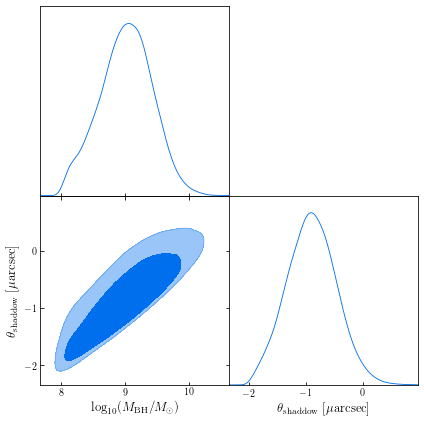

In [301]:
names2 = ["mass", "qsahd"]
labels2 =  ['$\log_{10}(M_{\\rm{BH}}/M_\odot)$' , '$\\theta_{\\rm{shaddow}}\;[\mu\\rm{arcsec}]$']

m_qshad_lis=np.transpose(np.array([m_d_lis[:,0],qshadlis]))


samples2 = MCSamples(samples=m_qshad_lis,names = names2, labels = labels2,settings={'smooth_scale_2D':0.3,'contours': [0.90, 0.99]})


# g = plots.get_single_plotter(width_inch=4, ratio=1)
# g.plot_2d(samples, 'x0', 'x1', filled=True)
# g.add_legend(['sim 1', 'sim 2'], colored_text=True);

# Triangle plot
g = plots.get_subplot_plotter(subplot_size=3)
g.triangle_plot(samples2, filled=True)


In [302]:
np.savetxt('sample.dat',m_qshad_lis)

In [224]:
nmuas=np.array([np.sum(qshadlis>x)/2000
            for x in np.linspace(1,50,100)])

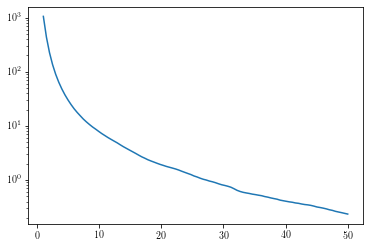

In [225]:
plt.semilogy(np.linspace(1,50,100),nmuas)
plt.show()

In [288]:
cut_samps5 = m_qshad_lis[m_qshad_lis[:,1]>np.log10(5),:]
cut_samples5 = MCSamples(samples=cut_samps5, names = names2, labels = labels2, 
                        ranges={'x0':(1, None)}, label='Cut samples',settings={'smooth_scale_1D':0.3})
cut_samps10 = m_qshad_lis[m_qshad_lis[:,1]>np.log10(10),:]
cut_samples10 = MCSamples(samples=cut_samps10, names = names2, labels = labels2, 
                        ranges={'x0':(1, None)}, label='Cut samples',settings={'smooth_scale_1D':0.3})
cut_samps20 = m_qshad_lis[m_qshad_lis[:,1]>np.log10(20),:]
cut_samples20 = MCSamples(samples=cut_samps20, names = names2, labels = labels2, 
                        ranges={'x0':(1, None)}, label='Cut samples',settings={'smooth_scale_1D':0.3})

Removed no burn in
Removed no burn in
Removed no burn in


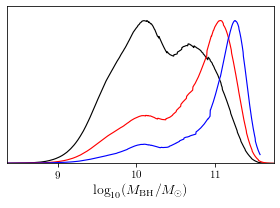

In [295]:
g = plots.get_single_plotter(width_inch=4)
g.plot_1d([cut_samples5, cut_samples10,cut_samples20], 'mass')

In [296]:
mass_new.size

38928

/Users/nadavoutmezguine/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """Entry point for launching an IPython kernel.


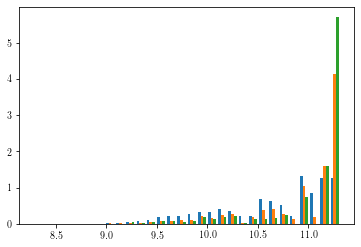

In [235]:
plt.hist([m_d_lis[qshadlis>10][:,0],m_d_lis[qshadlis>20][:,0],m_d_lis[qshadlis>30][:,0]],bins=30,normed=True)
plt.show()

In [318]:
from tqdm import *
samples=m_qshad_lis
m_min, theta_min = np.min(samples, axis=0)
m_max, theta_max = np.max(samples, axis=0)
# Cuts in theta
theta_cuts = np.linspace(theta_min, theta_max, 20)

median_ary = []
onesigma_ary = []
twosigma_ary = []
onesigma1_ary = []
twosigma1_ary = []

for theta_cut in tqdm_notebook(theta_cuts[:-1]):
    samples_cut = samples[samples[:, 1] > theta_cut][:, 0]
    median_ary.append(np.percentile(samples_cut,50))
    onesigma_ary.append(np.percentile(samples_cut, 68))
    onesigma1_ary.append(np.percentile(samples_cut, 100-68))
    twosigma_ary.append(np.percentile(samples_cut, 95))
    twosigma1_ary.append(np.percentile(samples_cut, 100-95))


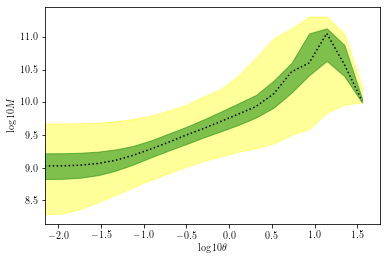

In [319]:
plt.plot(theta_cuts[:-1], median_ary, color='k', ls='dotted')
plt.fill_between(theta_cuts[:-1], twosigma1_ary,twosigma_ary, alpha=0.4, color='yellow')
plt.fill_between(theta_cuts[:-1], onesigma1_ary,onesigma_ary, alpha=0.5, color='green')

plt.xlim(theta_cuts[0], theta_cuts[-1])

plt.xlabel(r"$\log10 \theta$")
plt.ylabel(r"$\log10 M$")
plt.show()

In [435]:
data

FITS_rec([('000006.53+003055.2', 2.72279996e-02,  0.51534098, 1.82459998,  685, 467, 52203, 34603008, 1, 0, -25.38649105, 46.03577387, 0.03696207, 0,  0, 0., -27.60183648, -1., 0., -1., 45.32396665, 0.03696207, 45.60156197,  0.02962654, 0., -1., 0., -1., 0., -1., 0., -1., 0., -1., 0., -1., 0., -1., 0., -1., 0., -1., 0., -1., 0., -1., 0., -1., 0., -1., -999., -1., 0, 0., -1., 0., -1., 0., -1., 0., -1., 0., -1., 0., -1., 0., -1., 0., 0., -1., 0., -1., 0., -1., 0., -1., 0., -1., -999., -1., 0, 0., -1., 43.62372589, 0.06585654, 3954.80925985, 2410.85057003, 52.71140822, 7.69109269, 43.58683568, 0.05908359, 7273.24895784, 1605.91926143, 48.41884303, 7.1759815 , 7672.0224797 , 175.05358914, 49.48653517, -1.8229801 , 0.22336205, 310,  3.55194369, 1.13965962, 44.139111  ,  0.06932815, 7587.32421875,  1.17849683e+03, 57.70443173, 11.28997371,   -1.55148878,  0.52125338, 280, 5.02289818,  0.85850593, 300000., -1., 300000., -1., 300000., -1., 300000., -1.,  -244.41228097, 695.62330213, 9.36428829